<a href="https://colab.research.google.com/github/ngotrithu/Income-Classification---DeepNeuralNetwork---Pytorch/blob/main/Income_Classification_DeepNeuralNetwork_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mục đích:
* Dự đoán liệu thu nhập hàng năm của một người trưởng thành lớn hơn hay nhỏ hơn $50k một năm hay không?
* Sự bất bình đẳng về tài sản và thu nhập là một mối quan tâm sâu sắc của các chính phủ đặc biệt là ở các quốc gia đang phát triển như Mĩ và Châu Âu. Nguyên tắc phổ quát trong bình đẳng thu nhập đảm bảo phát triển bền vững và cải thiện sự ổn định kinh tế của một quốc gia. Việc áp dụng các kỹ thuật học máy và khai thác dữ liệu trong cung cấp giải pháp cho vấn đề bình đẳng thu nhập là khả thi và nhiều triển vọng

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
os.chdir('drive/My Drive/Colab Notebooks')
!ls dataset

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
creditcard.csv	    realestate.csv  weatherAUS_2.csv
Customer-Churn.csv  test.csv	    weatherAUS.csv
data		    train.csv	    weatherdata.csv


##Import Package and Load data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
import torch
import torch.nn as nn
import torch.utils.data as td

In [ ]:
df=pd.read_csv('dataset/train.csv')
df.head()

,ID,age,work_type,final_weight,education,total_education_yrs,marital_state,job,status,ethnicity,sex,capital_gain,capital_loss,hrs_per_week,nationality,target_income
0,0,45,Private,175925,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,M,0,0,40,US,0
1,1,23,Private,113601,Some-college,10,Never-married,Handlers-cleaners,Own-child,White,M,0,0,30,US,0
2,2,22,Private,112137,Some-college,10,Never-married,Prof-specialty,Other-relative,Asian-Pac-Islander,F,0,0,20,South,0
3,3,27,Private,153078,Prof-school,15,Never-married,Prof-specialty,Own-child,Asian-Pac-Islander,M,0,0,40,US,0
4,4,18,Private,375515,11th,7,Never-married,Sales,Own-child,White,F,0,0,20,US,0


In [ ]:
df=df.drop(['ID'],axis=1)

##Understanding the Data

In [ ]:
df.shape

(25000, 15)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  25000 non-null  int64 
 1   work_type            25000 non-null  object
 2   final_weight         25000 non-null  int64 
 3   education            25000 non-null  object
 4   total_education_yrs  25000 non-null  int64 
 5   marital_state        25000 non-null  object
 6   job                  25000 non-null  object
 7   status               25000 non-null  object
 8   ethnicity            25000 non-null  object
 9   sex                  25000 non-null  object
 10  capital_gain         25000 non-null  int64 
 11  capital_loss         25000 non-null  int64 
 12  hrs_per_week         25000 non-null  int64 
 13  nationality          25000 non-null  object
 14  target_income        25000 non-null  int64 
dtypes: int64(7), object(8)
memory usage: 2.9+ MB


Bộ dữ liệu có 2500 quan sát và 16 biến. Trong đó có 8 biến numerical và 8 biến categorical

In [ ]:
df.isnull().sum()

age                    0
work_type              0
final_weight           0
education              0
total_education_yrs    0
marital_state          0
job                    0
status                 0
ethnicity              0
sex                    0
capital_gain           0
capital_loss           0
hrs_per_week           0
nationality            0
target_income          0
dtype: int64

In [ ]:
#Kiểm tra ký tự '?' trong dataset
def cc(x):
    return sum(x=='?')
df.apply(cc)

age                       0
work_type              1379
final_weight              0
education                 0
total_education_yrs       0
marital_state             0
job                    1384
status                    0
ethnicity                 0
sex                       0
capital_gain              0
capital_loss              0
hrs_per_week              0
nationality             443
target_income             0
dtype: int64

Bộ dữ liệu này không có missing values nhưng có ký tự `?` trong các feature. Chúng ta cần replace chúng sang `np.nan` sau đó áp dụng các cách xử lý missing values như bình thường


In [ ]:
df.replace('?', np.nan, inplace = True)

In [ ]:
df.isnull().sum()

age                       0
work_type              1379
final_weight              0
education                 0
total_education_yrs       0
marital_state             0
job                    1384
status                    0
ethnicity                 0
sex                       0
capital_gain              0
capital_loss              0
hrs_per_week              0
nationality             443
target_income             0
dtype: int64

##Handle Missing Values

In [ ]:
nan_cols = [i for i in df.columns if df[i].isnull().any()]
print(nan_cols)

['work_type', 'job', 'nationality']


Bộ dữ liệu này có ba features có missing values. Và cả ba đều là biến categorical nên chúng ta sẽ áp dụng kỹ thuật mode để xử lý missing values của những features này

In [ ]:
df['work_type'].fillna(df['work_type'].mode()[0], inplace=True)
df['job'].fillna(df['job'].mode()[0], inplace=True)
df['nationality'].fillna(df['nationality'].mode()[0], inplace=True)

In [ ]:
df.isnull().sum()

age                    0
work_type              0
final_weight           0
education              0
total_education_yrs    0
marital_state          0
job                    0
status                 0
ethnicity              0
sex                    0
capital_gain           0
capital_loss           0
hrs_per_week           0
nationality            0
target_income          0
dtype: int64

In [ ]:
df['target_income'].value_counts()/len(df)

0    0.76056
1    0.23944
Name: target_income, dtype: float64

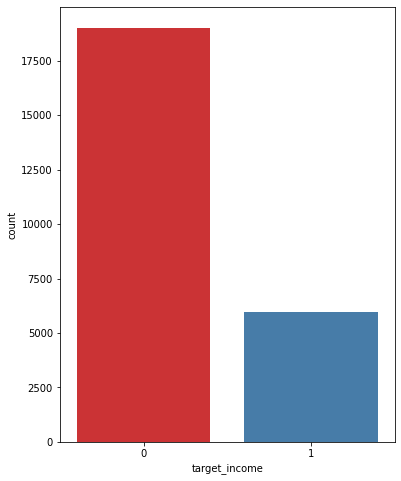

In [ ]:
f,ax = plt.subplots(figsize=(6,8))
ax = sns.countplot(x='target_income', data=df, palette='Set1')
plt.show()

In [ ]:
df.describe()

,age,final_weight,total_education_yrs,capital_gain,capital_loss,hrs_per_week,target_income
count,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.000000,25000.000000,25000.00000
mean,38.568800,1.900156e+05,10.079160,1051.950240,86.053160,40.392200,0.23944
std,13.642694,1.059694e+05,2.566125,7228.975017,400.535454,12.350547,0.42675
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000,0.00000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000,0.00000
50%,37.000000,1.786440e+05,10.000000,0.000000,0.000000,40.000000,0.00000
75%,48.000000,2.368040e+05,12.000000,0.000000,0.000000,45.000000,0.00000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000,1.00000


Kết quả thống kê mô tả sơ bộ trên các biến numeric cho thấy các biến khác biệt nhau về độ lớn đơn vị. Trung bình thấp nhất là 10.079 và cao nhất lên tới 190015.63. Như vậy khả năng cao chúng ta sẽ cần phải chuẩn hoá các biến để loại bỏ sự khác biệt về đơn vị trước khi xây dựng mô hình. 

##Visualization

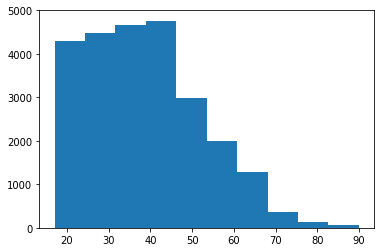

In [ ]:
plt.hist(df['age']);

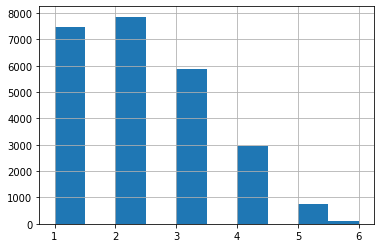

In [ ]:
df['age'] = pd.cut(df['age'], 6, labels = [1,2,3,4,5,6])
df.age.hist()

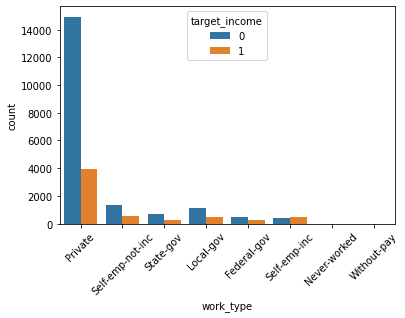

In [ ]:
#work_type vs target_incom
sns.countplot(x = 'work_type', hue = 'target_income', data = df)
plt.xticks(rotation=45);

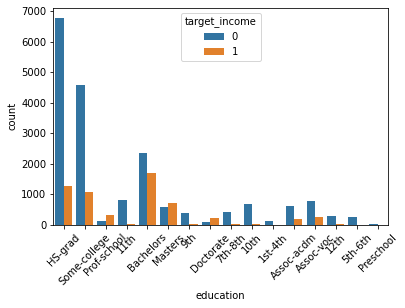

In [ ]:
#education vs target_incom
sns.countplot(x = 'education', hue = 'target_income', data = df)
plt.xticks(rotation=45);

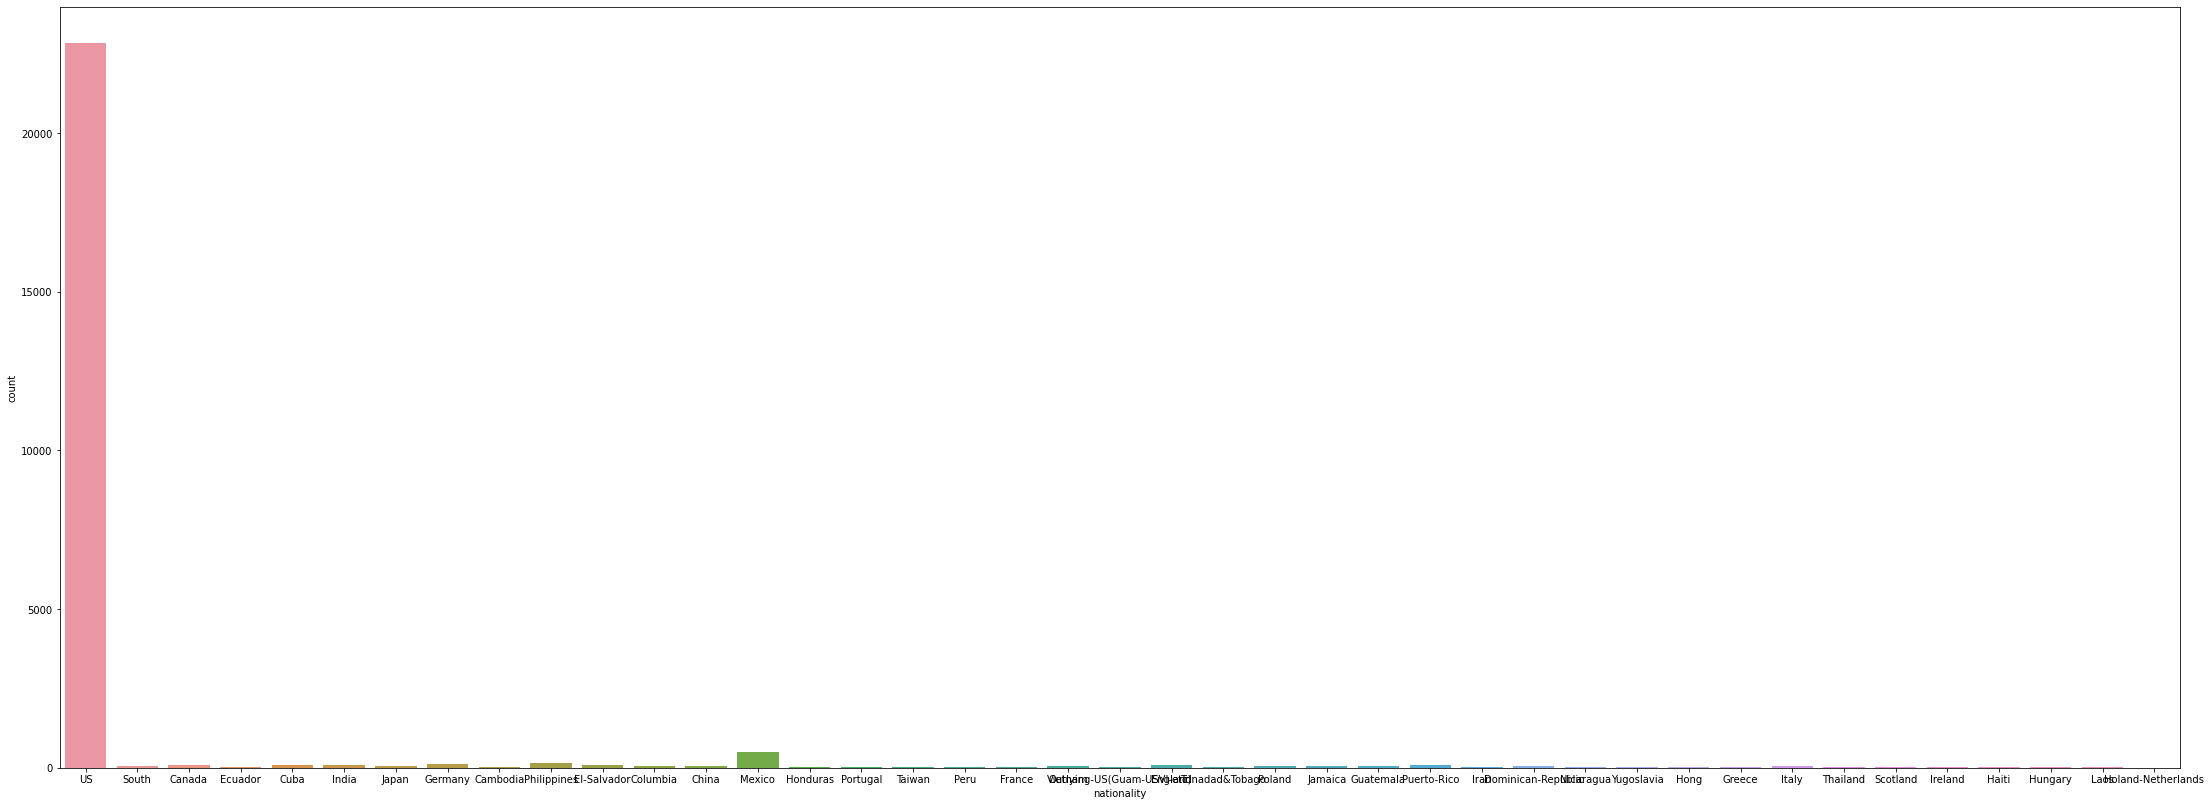

In [ ]:
#explore which country do most people belong
plt.figure(figsize=(38,14))
sns.countplot(x='nationality',data= df)
plt.show()

Các quan sát từ `US` khá nhiều nên chúng ta có thể gộp các nước khác thành `Other`

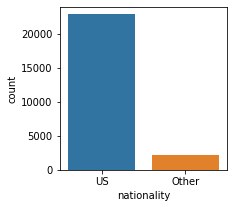

In [ ]:
df.loc[df['nationality']!='US','nationality'] = 'Other'
plt.figure(figsize=(3,3))
sns.countplot(x='nationality',data=df)
plt.show()

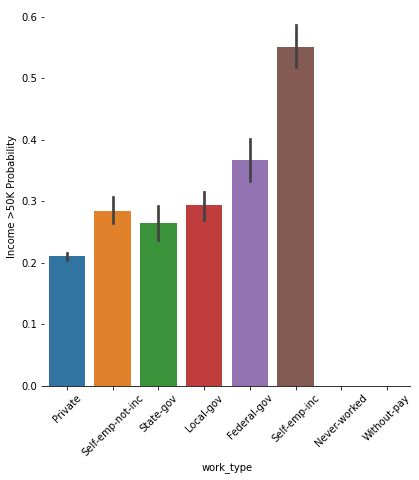

In [ ]:
# Income >50K Probability with work_type
g = sns.catplot(x='work_type',y='target_income',data=df,kind='bar',height=6)
plt.xticks(rotation=45)
g.despine(left=True)
g = g.set_ylabels("Income >50K Probability")
plt.show()

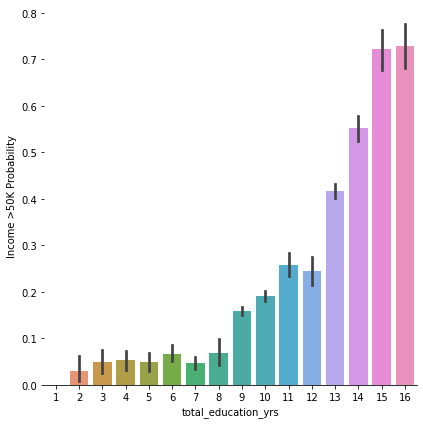

In [ ]:
# Income >50K Probability with Total Edu Years
g = sns.catplot(x='total_education_yrs',y='target_income',data= df,kind='bar',height=6)
g.despine(left=True)
g = g.set_ylabels("Income >50K Probability")
plt.show()

Trình độ học vấn càng cao thì thu nhập càng cao (Điều này khá rõ ràng)

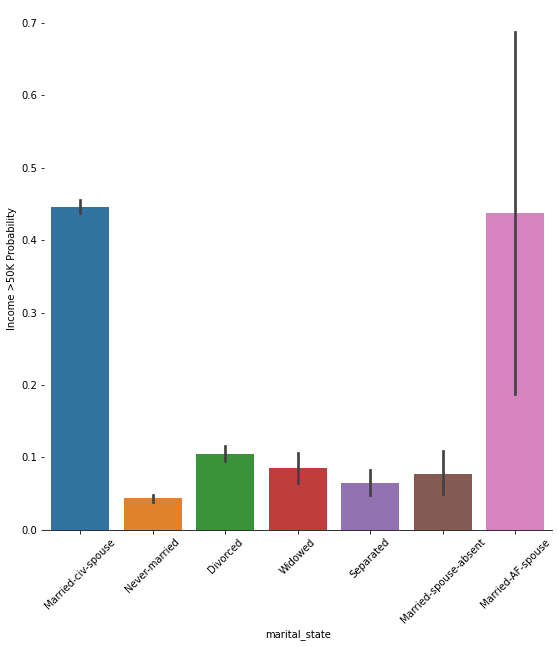

In [ ]:
# Income >50K Probability with marital_state
g = sns.catplot(x='marital_state',y='target_income',data=df,kind='bar',height=8)
plt.xticks(rotation=45)
g.despine(left=True)
g = g.set_ylabels("Income >50K Probability")
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3750: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


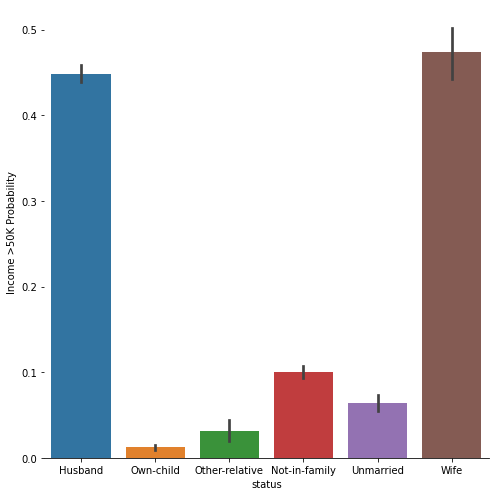

In [ ]:
# Income >50K Probability with status
g = sns.catplot(x='status',y='target_income',data=df,kind='bar',size=7)
g.despine(left=True)
g = g.set_ylabels("Income >50K Probability")
plt.show();

#Spliting the data

In [ ]:
X = df.drop('target_income', axis=1)
y = df['target_income']

In [ ]:
df_all_one_hot = pd.get_dummies(X)
X = df_all_one_hot.columns.tolist()
y = y.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_all_one_hot[X].values, # input variable
                                                    y, # output variable
                                                    test_size=0.2, # test dataset proportion
                                                    random_state=0) # keep train/test split the same if run again. 
print ('Training Set: %d, Test Set: %d \n' % (len(X_train), len(X_test)))
#normalize
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Training Set: 20000, Test Set: 5000 



In [ ]:
import pickle
def _save_pkl(path, obj):
  with open(path, 'wb') as f:
    pickle.dump(obj, f)
def _load_pkl(path):
  with open(path, 'rb') as f:
    obj = pickle.load(f)
  return obj
_save_pkl('scaler.pkl', sc)

In [ ]:
#metric
def get_metrics(y_test, y_pred):
    print('ACCURACY_SCORE: ', round(accuracy_score(y_test, y_pred), 4))
    print('F1_SCORE: ', round(f1_score(y_test, y_pred, average='macro'), 4))
    print('CONFUSION_MATRIX:\n', confusion_matrix(y_test, y_pred),'\n')
    print(classification_report(y_test, y_pred, digits=4), '\n')

In [ ]:
# Create a dataset and loader for the training data and labels
train_X = torch.Tensor(X_train).float()
train_y = torch.Tensor(y_train).float()
train_ds = td.TensorDataset(train_X,train_y)

# Create a dataset and loader for the test data and labels
test_X = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).float()
test_ds = td.TensorDataset(test_X,test_y)
print('Ready to load data')

Ready to load data


# Build up model architecture

In [ ]:
# Number of hidden layer nodes
hl = 10

# Define the neural network
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(len(X), hl)
        self.bn1 = nn.BatchNorm1d(hl)
        self.fc2 = nn.Linear(hl, hl)
        self.bn2 = nn.BatchNorm1d(hl)
        self.fc3 = nn.Linear(hl, 6)
        self.bn3 = nn.BatchNorm1d(6)
        self.drop = nn.Dropout(0.5)
        self.fc4 = nn.Linear(6, 1)
        self.acts = [nn.ReLU(), nn.ReLU(), nn.Sigmoid()] # List activation khác nhau

    def forward(self, x):
        x = self.acts[0](self.fc1(x))
        x = self.bn1(x)
        x = self.acts[1](self.fc2(x))
        x = self.bn2(x)
        x = self.acts[2](self.fc3(x))
        x = self.bn3(x)
        x = self.drop(x)
        x = torch.sigmoid(self.fc4(x)) # trả về 1 unit thể hiện xs dự báo P(y=1|X)
        return x

# Create a model instance from the network
model = Model()
print(model)

Model(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)


# Initialize weight and optimizer

In [ ]:
from torch import nn
def init_weights(m, init_type = 'xavier'):
    if type(m) == nn.Linear:
      if init_type == 'xavier':
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'normal':
        torch.nn.init.normal_(m.weight)
        m.bias.data.fill_(0.01)
      elif init_type == 'he':
        torch.nn.init.kaiming_uniform_(m.weight)
        m.bias.data.fill_(0.01)

## Khởi tạo hệ số theo `normal`

In [ ]:
model.apply(lambda m: init_weights(m, init_type = 'normal'))

Model(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
# Quá trình train

def train(model, data_loader, optimizer):
  # Set mode cho mô hình
    model.train() # Đặt mô hình ở trạng thái huấn luyện
    train_loss = 0 # Khai báo loss function = 0
    
    for batch, tensor in enumerate(data_loader): #load batch và tensor
        data, target = tensor

        # feedforward: tính toán y_pred và loss function
        optimizer.zero_grad() # sau mỗi vòng lặp cập nhật GD về 0 tránh TH cộng dồn của nhiều mini-batch trước đó
        # Giá trị dự báo
        out = model(data)
        # Tính loss
        loss = loss_criteria(out, target.reshape(-1,1))
        train_loss += loss.item()

        #backpropagation:
        loss.backward() # Tính gradient descent
        optimizer.step() # cập nhật trọng số cho mô hình
    # trả về trung bình loss
    avg_loss = train_loss / (batch+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
           
# Quá trình test          
def test(model, data_loader):

    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad(): # ngăn chặn việc sử dụng gd của các mini-batch trước đó
        batch_count = 0
        for batch, tensor in enumerate(data_loader):
            batch_count += 1
            data, target = tensor
            # Dự báo
            out = model(data)

            # tính loss
            test_loss += loss_criteria(out, target.reshape(-1,1)).item()

            # Tính accuracy
            predicted = [1 if i>0.5 else 0 for i in out.data]
            predicted = torch.tensor(predicted)

            correct += torch.sum(target==predicted).item()
            
    # Tính trung bình loss and tổng accuracy cho epoch đang huấn luyện
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.6f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))
    
    # trả về trung bình loss của epoch
    return avg_loss

## Thay đổi loss function, optimizer, batch_size

In [ ]:
train_loader = td.DataLoader(train_ds, batch_size=64,
    shuffle=True, num_workers=2)
test_loader = td.DataLoader(test_ds, batch_size=64,
    shuffle=False, num_workers=2)

## Khởi tạo hệ số theo `he`

In [ ]:
model.apply(lambda m: init_weights(m, init_type = 'he'))

Model(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
loss_criteria = nn.HuberLoss() # có thể dùng nn.BCELoss(), CrossEntropyLoss()
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad() # Thiết lập gd về 0
epoch_nums = []
training_loss = []
validation_loss = []
epochs = 30
for epoch in range(1, epochs + 1):
    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Lấy dữ liệu từ train_loader fit vào model và cập nhật gd qua optimizer
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.082087
Validation set: Average loss: 0.053129, Accuracy: 4248/5000 (85%)

Epoch: 2
Training set: Average loss: 0.059063
Validation set: Average loss: 0.052215, Accuracy: 4223/5000 (84%)

Epoch: 3
Training set: Average loss: 0.056740
Validation set: Average loss: 0.050817, Accuracy: 4251/5000 (85%)

Epoch: 4
Training set: Average loss: 0.055739
Validation set: Average loss: 0.050329, Accuracy: 4267/5000 (85%)

Epoch: 5
Training set: Average loss: 0.055546
Validation set: Average loss: 0.051251, Accuracy: 4231/5000 (85%)

Epoch: 6
Training set: Average loss: 0.055309
Validation set: Average loss: 0.050825, Accuracy: 4242/5000 (85%)

Epoch: 7
Training set: Average loss: 0.054858
Validation set: Average loss: 0.051145, Accuracy: 4243/5000 (85%)

Epoch: 8
Training set: Average loss: 0.055051
Validation set: Average loss: 0.052254, Accuracy: 4251/5000 (85%)

Epoch: 9
Training set: Average loss: 0.054149
Validation set: Average loss: 0.050847, Accuracy: 

## Eveluate on test with `he`

Evaluation on test dataset
ACCURACY_SCORE:  0.8498
F1_SCORE:  0.769
CONFUSION_MATRIX:
 [[3603  208]
 [ 543  646]] 

              precision    recall  f1-score   support

           0     0.8690    0.9454    0.9056      3811
           1     0.7564    0.5433    0.6324      1189

    accuracy                         0.8498      5000
   macro avg     0.8127    0.7444    0.7690      5000
weighted avg     0.8423    0.8498    0.8406      5000
 



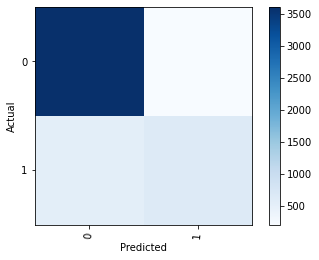

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
def _evaluate(model, x_test):
  model.eval()
  x = torch.Tensor(x_test).float()
  predictions = [1 if i>0.5 else 0 for i in model(x).data]
  predictions = torch.tensor(predictions)
  print('Evaluation on test dataset')
  get_metrics(y_test, predictions)

  # Plot the confusion matrix
  classes=['0','1']
  cm = confusion_matrix(y_test, predictions)
  plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
  plt.colorbar()
  tick_marks = np.arange(2)
  plt.xticks(tick_marks, classes, rotation=85)
  plt.yticks(tick_marks, classes)
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.show()
_evaluate(model, X_test)

## Khởi tạo hệ số theo `xavier`

In [ ]:
model.apply(lambda m: init_weights(m, init_type = 'xavier'))

Model(
  (fc1): Linear(in_features=71, out_features=10, bias=True)
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=10, out_features=10, bias=True)
  (bn2): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=10, out_features=6, bias=True)
  (bn3): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop): Dropout(p=0.5, inplace=False)
  (fc4): Linear(in_features=6, out_features=1, bias=True)
)

In [ ]:
loss_criteria = nn.HuberLoss()
learning_rate = 0.003
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.zero_grad()
epoch_nums = []
training_loss = []
validation_loss = []
epochs = 30
for epoch in range(1, epochs + 1):
    # print the epoch number
    print('Epoch: {}'.format(epoch))
    
    # Feed training data into the model to optimize the weights
    train_loss = train(model, train_loader, optimizer)
    
    # Feed the test data into the model to check its performance
    test_loss = test(model, test_loader)
    
    # Log the metrics for this epoch
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.079896
Validation set: Average loss: 0.054076, Accuracy: 4203/5000 (84%)

Epoch: 2
Training set: Average loss: 0.059182
Validation set: Average loss: 0.051650, Accuracy: 4242/5000 (85%)

Epoch: 3
Training set: Average loss: 0.057547
Validation set: Average loss: 0.051644, Accuracy: 4227/5000 (85%)

Epoch: 4
Training set: Average loss: 0.056229
Validation set: Average loss: 0.050971, Accuracy: 4239/5000 (85%)

Epoch: 5
Training set: Average loss: 0.055048
Validation set: Average loss: 0.050365, Accuracy: 4262/5000 (85%)

Epoch: 6
Training set: Average loss: 0.054208
Validation set: Average loss: 0.050827, Accuracy: 4231/5000 (85%)

Epoch: 7
Training set: Average loss: 0.054578
Validation set: Average loss: 0.050224, Accuracy: 4258/5000 (85%)

Epoch: 8
Training set: Average loss: 0.054255
Validation set: Average loss: 0.050220, Accuracy: 4236/5000 (85%)

Epoch: 9
Training set: Average loss: 0.054263
Validation set: Average loss: 0.050988, Accuracy: 

## Eveluate on test with `xaver`

Evaluation on test dataset
ACCURACY_SCORE:  0.8526
F1_SCORE:  0.7769
CONFUSION_MATRIX:
 [[3588  223]
 [ 514  675]] 

              precision    recall  f1-score   support

           0     0.8747    0.9415    0.9069      3811
           1     0.7517    0.5677    0.6469      1189

    accuracy                         0.8526      5000
   macro avg     0.8132    0.7546    0.7769      5000
weighted avg     0.8454    0.8526    0.8450      5000
 



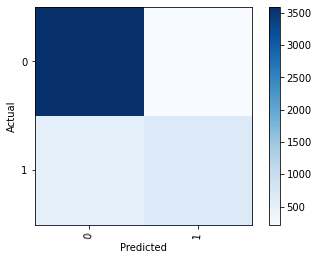

In [ ]:
_evaluate(model, X_test)

Như vậy khởi tạo `xavier` tốt hơn so với `he`

#Fine tuning

In [ ]:
!pip install --quiet optuna

In [ ]:
import optuna
from optuna.trial import TrialState
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Create a dataset and loader for the training data and labels
train_x = torch.Tensor(X_train).float()
train_y = torch.Tensor(y_train).float()
train_ds = td.TensorDataset(train_x,train_y)
train_loader = td.DataLoader(train_ds, batch_size=32,
    shuffle=True, num_workers=2)

# Create a dataset and loader for the test data and labels
test_x = torch.Tensor(X_test).float()
test_y = torch.Tensor(y_test).float()
test_ds = td.TensorDataset(test_x,test_y)
test_loader = td.DataLoader(test_ds, batch_size=32,
    shuffle=False, num_workers=2)
print('Ready to load data')

Ready to load data


In [ ]:
  # Thiết lập không gian search
  def define_model(trial):
      # We optimize the number of layers, hidden units and dropout ratio in each layer.
      n_layers = trial.suggest_int("n_layers", 2, 5) # Khởi tại không gian layers
      layers = []
      act_layers = {
          'relu': nn.ReLU(),
          'sigmoid': nn.Sigmoid(),
          'gelu': nn.GELU(),
      }

      in_features = len(X)
      # Khởi tạo cho từng layers
      for i in range(n_layers):
          out_features = trial.suggest_int("n_units_l{}".format(i), 20, 200)
          layers.append(nn.Linear(in_features, out_features)) #FC
          layers.append(nn.BatchNorm1d(out_features)) # Batch normalization
          act_type = trial.suggest_categorical("act_type", ['relu', 'sigmoid', 'gelu'])
          layers.append(act_layers[act_type]) # Sau mỗi layer sẽ dùng 1 trong 3 activation đã khởi tạo
          p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.6) # Tỷ lệ drop-out ngẫu nhiên từ 0.2 đến 0.6
          layers.append(nn.Dropout(p))
          in_features = out_features
      layers.append(nn.Linear(in_features, 1))
      layers.append(nn.Sigmoid())

      return nn.Sequential(*layers)

In [ ]:
DEVICE = torch.device("cpu") #Huấn luyện mô hình trên CPU
BATCHSIZE = 32
EPOCHS = 30
LOG_INTERVAL = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 500
N_VALID_EXAMPLES = BATCHSIZE * 100

def objective(trial):

    # Khởi tạo kiến trúc
    model = define_model(trial).to(DEVICE)

    # Khởi tạo optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True) # Vì lr không có pp đều nên cần biến đổi log lr để search trên kgian log
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
    # Generate the loss function
    criteria_name = trial.suggest_categorical("criterial", ['BCELoss', 'HuberLoss'])
    criteria_dict = {
        'BCELoss': nn.BCELoss(),
        'HuberLoss': nn.HuberLoss()
    }
    loss_criteria = criteria_dict[criteria_name]
    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = loss_criteria(output, target.reshape(-1,1))
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = torch.tensor(output.data>=0.5).float()
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(test_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch) # tracking lại các accuracy và epoch tương ứng

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=1000)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-03-22 10:03:39,398] A new study created in memory with name: no-name-4c3a84b3-f236-4b25-9866-04357f40c235
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
[I 2022-03-22 10:05:23,690] Trial 0 finished with value: 0.853125 and parameters: {'n_layers': 3, 'n_units_l0': 200, 'act_type': 'gelu', 'dropout_l0': 0.28914361939901434, 'n_units_l1': 83, 'dropout_l1': 0.440029172043498, 'n_units_l2': 89, 'dropout_l2': 0.4925781551921577, 'optimizer': 'Adam', 'lr': 0.0002552941729813259, 'criterial': 'BCELoss'}. Best is trial 0 with value: 0.853125.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torc

Study statistics: 
  Number of finished trials:  17
  Number of pruned trials:  8
  Number of complete trials:  9
Best trial:
  Value:  0.8565625
  Params: 
    n_layers: 3
    n_units_l0: 179
    act_type: relu
    dropout_l0: 0.5618703885573135
    n_units_l1: 186
    dropout_l1: 0.26163038907552916
    n_units_l2: 57
    dropout_l2: 0.2982459294241378
    optimizer: Adam
    lr: 0.0005969929271689646
    criterial: BCELoss


In [ ]:
model = define_model(trial)

In [ ]:
loss_criteria = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), 
                       lr=trial.params['lr'])
optimizer.zero_grad()

# We'll track metrics for each epoch in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Tăng epoch lên
epochs = 100
for epoch in range(1, epochs + 1):
    print('Epoch: {}'.format(epoch))
    train_loss = train(model, train_loader, optimizer)
    test_loss = test(model, test_loader)
    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    validation_loss.append(test_loss)

Epoch: 1
Training set: Average loss: 0.398383
Validation set: Average loss: 0.326364, Accuracy: 4232/5000 (85%)

Epoch: 2
Training set: Average loss: 0.356109
Validation set: Average loss: 0.319122, Accuracy: 4227/5000 (85%)

Epoch: 3
Training set: Average loss: 0.345342
Validation set: Average loss: 0.312835, Accuracy: 4245/5000 (85%)

Epoch: 4
Training set: Average loss: 0.342670
Validation set: Average loss: 0.320077, Accuracy: 4230/5000 (85%)

Epoch: 5
Training set: Average loss: 0.336251
Validation set: Average loss: 0.309610, Accuracy: 4254/5000 (85%)

Epoch: 6
Training set: Average loss: 0.337016
Validation set: Average loss: 0.309079, Accuracy: 4255/5000 (85%)

Epoch: 7
Training set: Average loss: 0.333517
Validation set: Average loss: 0.309031, Accuracy: 4266/5000 (85%)

Epoch: 8
Training set: Average loss: 0.334849
Validation set: Average loss: 0.309942, Accuracy: 4268/5000 (85%)

Epoch: 9
Training set: Average loss: 0.330154
Validation set: Average loss: 0.310116, Accuracy: 

Evaluation on test dataset
ACCURACY_SCORE:  0.8538
F1_SCORE:  0.7901
CONFUSION_MATRIX:
 [[3512  299]
 [ 432  757]] 

              precision    recall  f1-score   support

           0     0.8905    0.9215    0.9057      3811
           1     0.7169    0.6367    0.6744      1189

    accuracy                         0.8538      5000
   macro avg     0.8037    0.7791    0.7901      5000
weighted avg     0.8492    0.8538    0.8507      5000
 



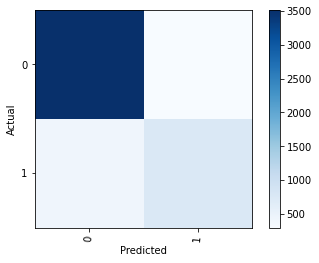

In [ ]:
_evaluate(model, X_test)

Sử dụng tham số mới thì acc đã tăng lên 0.8538

#Save model

In [ ]:
model_file = 'model.pt'
torch.save(model.state_dict(), model_file)
del model

In [ ]:
_save_pkl('trial.pkl', trial)